# **Intro to boosting**



### Imports

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [18]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

## The idea of boosting

[Reference](https://proproprogs.ru/ml/ml-vvedenie-v-boosting-algoritm-adaboost-pri-klassifikacii)

**Boosting** (originally called hypothesis boosting) refers to any ensemble method that combines several weak classifiers (weak learners) into one strong one (strong learner). The general idea of most boosting algorithms is to train predictors sequentially, so that each predictor tries to correct the predecessor. There are many boosting algorithms known, but the most popular are the **AdaBoost** (Adaptive Boosting) and **Gradient Boosting** algorithms.

$$a(x) = \sum_{t=1}^{T}\alpha_t * b_t(x)$$  
$\alpha_t$ - predictor's weight   
$b_t(x)$ - predictor's outputs (вещественные значения; logits ($< wx >$), answers 1 or -1, etc.)  
$T$ - the total number of predictors  

**Which algorithm (predictor) we use as a baseline?**

A **decision tree** is usually taken.

The main requirement for algorithms in composition is their **simplicity** and **speed** of construction and training.

Each individual model must be far from ideal (**does not have good generalizing properties**) and different from the previous one, otherwise the sense of boosting disappears.  
The decision tree meets these requirements.

**Which error we want to minimize?**

**Regression**: typically squared error loss.

$$ Q_T = \frac{1}{2}\sum_{i=1}^{l} (y_i - b(x_i))^2 --> min $$

**Classification**:

image.png

M - margin.

image.png

Remember that a classifier is trained to make the negative scalar product $<x_i, w_i>$ for class "0", and the positive scalar product for class "1".

The smaller the margin value, the closer the object is to the class boundary, respectively, the higher the probability of an incorrect prediction.

The margin is negative --> the classifier makes an error on this object.

We want to select weights and algorithms in such a way that the ensemble has as few classification errors as possible:

$ Q_T = \sum_{i=1}^{l} [M(x_i) < 0] $ (count the number of objects with negative margin)  
or  
$Q_T = \sum_{i=1}^{l} [y_i * \sum_{t=1}^{T}a(x) < 0] = \sum_{i=1}^{l} [y_i * \sum_{t=1}^{T}a_t b_t(x_i) < 0]$  

Solving the problem of finding suitable weights and algorithms for minimizing this function is very **difficult**.  

The following heuristics were proposed:
1. **Greedy composition construction** - let's select the predictor $b_t$ and the weight $a_t$ with the **fixed** previously found predictors and weights. That is, at each step $t$, we will calculate **only one weighting factor** $a_t$ and train **only one predictor** $b_t$ on those objects from the training sample on which previous predictors showed weak results.  
2. Let's approximate the rough functional with a **smooth and differentiable loss function** so that the optimization problem is easier to solve.


These heuristics underlie most boosting algorithms.

In this notebook, we will focus on the AdaBoost algorithm for classification and gradient boosting for regression.  
  
Note that both algorithms can be used for both regression and classification.

# 1. **Adaboost**

## Adaboost (binary classification)  

One of the ways a new predictor can correct the mistakes of the previous one is to pay a little more attention to those objects of the training sample on which the previous learner was **under-trained**.  
This leads to the new predictor focusing more on **complex cases**.  
This technique is the basis of the **AdaBoost** algorithm.

An **exponential loss function** is used to approximate the quality functional:  


image.png

$$ Q_T = \sum_{i=1}^{l} \exp(-M_t(x_i, y_i)) $$  
  
$$ Q_T = \sum_{i=1}^{l} \exp(-y_i * \sum_{t=1}^{T}a_t b_t(x_i)) $$

**Each predictor** in the ensemble outputs some number **for each object**.  
It can be a logit or just a sign (1 or -1).  

$ \sum_{t=1}^{T}a_t b_t(x_i) $ - the sum of the predictors' outputs $b_t(x_i)$ for the object $x_i$, where each output is multiplied by the weight $a_t$ corresponding to the current step $t$ (the predictor's weight at the current step $t$).  
Это вещественные числа, которые выдает ансамбль для каждого из объектов тренировочной выборки: знак указывает на ответ ансамбля, а модуль - на уверенность в классификации. Они получаются путем взвешивания вещественных чисел, которые выдает каждый из отдельных предикторов. Про вычисление весов пока не говорим.  



Multiplication by the **minus class labe**l $-y_i$ gives us a margin: **sign** (result of a classification) + **confidence** (module of a margin).

The minus is necessary in order to expect the necessary behavior of the exponent:  
1) raising the exponent to a negative degree (correct classification) - $Q_{Ti}$ for the object $x_i$ will be small;  
2) raising the exponent to a positive degree (incorrect classification) - $Q_{Ti}$ for the object $x_i$ will be large.

We build the algorithm in a **greedy way**: at the current step $t$, we fix all the previous outputs $b_t(x_i)$ and weights $a_t$ of the algorithms.

Thus, we can present $Q_T$ as follows:  
$$ Q_T = \sum_{i=1}^{l} \exp(-y_i * \sum_{t=1}^{T-1}a_t b_t(x_i)) * \exp(-y_i * a_T * b_T(x_i))$$  
$$ Q_T = \sum_{i=1}^{l} w_i * \exp(-y_i * a_T * b_T(x_i)) $$

$\exp(-y_i * \sum_{t=1}^{T-1}a_t b_t(x_i))$ is a weight of the current object $x_i$ at the current step $t$.    
  
**For the objects on which the ensemble made mistakes more often, the weights will be larger**!  

Thus, the idea of the Adaboost algorithm is to consistently train predictors on objects on which the previous composition (T - 1 predictors) made mistakes more often.

After that, each weight $w_i$ is normalized so that their sum among all objects is equal to one (necessary for computer implementation):  
$$w_{i} = \frac{w_{i}}{\sum_{j=1}^{l} w_j}$$

Further: how do we find out the weight of the algorithm $a_t$ at the step $t$?  


At the step $t$ we have the vector of weights $W$ (weights determine the significance of objects for the current predictor)

So we calculate the **weighted error rate** for the predictor $t$:  
$$r_t = \sum_{i=1}^{m}\lbrack\hat{y}^{(i)}\neq y^{(i)}\rbrack\cdot w^{(i)}$$

That is, we multiply the weights of the objects (that we got from the previous composition) in the training sample by the vector of zeros and ones, where zeros show correctly classified objects., e.g.:  
[0, 1, 1] * [1/3, 1/3, 1/3] = [0, 1/3, 1/3], $r_j$ = 2/3 (worse)    
[0, 0, 1] * [1/3, 1/3, 1/3] = [0, 0, 1/3], $r_j$ = 1/3 (better)  
  
[1, 0, 1] * [1/5, 2/5, 2/5] = [0.2, 0, 0.4], $r_j$ = 0.6 (better)    
[0, 1, 1] * [1/5, 2/5, 2/5] = [0, 0.4, 0.4], $r_j$ = 0.8 (worse)  

At the $t$ step, we are looking for an algorithm that minimizes its $r_t$:  
$$b_t = argmin(r_t)$$

Mathematicians have proved that the best weight $a_t$ for the current predictor can be obtained using the following formula:  
$$\alpha_t = \eta\times\ln\frac{1-r_t}{r_t}$$

where $\eta$ is a hyperparameter (learning rate), typically equals to 1/2.   
The more accurate the predictor is, the greater its weight will be.  
If it gives a simple random guess, then his weight will be close to zero.
However, if it's more often incorrect (less accurate than random guessing), then its weight will be negative.  

**These two formulas represent the whole idea of the Adaboost algorithm**.

## Adaboost pseudo-code & python code (binary classification)

**Input**: training sample $X_l$ and parameter $T$ (the number of predictors in an ensemble).  
**Output**: the number of trained algorithms $b_0, b_1, ..., b_T$ and their weights  $a_0, a_1, ..., a_T$

1. Initialization of the weights: $ w_i = \frac{1}{l} $ (equal weights); $\eta = \frac{1}{2}$.  
  
2. For each algorithm from $b_1$ to $b_t$:  
  
3. Find the best current algorithm according to the rule: $b_t = argmin(r_t)$
  
4. Find the coefficient (weight) of this algorithm using the formula: $\alpha_t = \eta\times\ln\frac{1-r_t}{r_t}$  
  
5. Recalculate object weights: $ w_i = w_i * \exp(-y_i * \alpha_t * b_t(x_i))$  

6. Normalize object weights so that their sum equals to 1: $w_{i} = \frac{w_{i}}{\sum_{j=1}^{l} w_j}$

![](https://www.safaribooksonline.com/library/view/hands-on-machine-learning/9781491962282/assets/mlst_0707.png)

Число ошибок на обучающей выборке: 13.0 при композиции 1 решающих деревьев


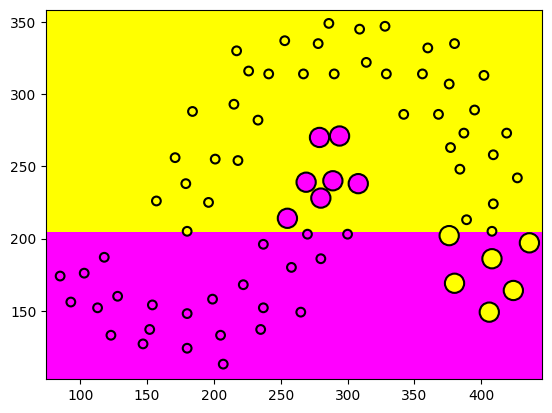

In [19]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 10, data[:, 0].max() + 10
    y_min, y_max = data[:, 1].min() - 10, data[:, 1].max() + 10
    return np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))


t = [[(85, 174), (93, 156), (103, 176), (113, 152), (123, 133), (128, 160),
 (147, 127), (152, 137), (180, 124), (180, 148), (205, 133), (207, 113),
  (199, 158), (222, 168), (235, 137), (237, 152), (265, 149), (258, 180),
  (237, 196), (255, 214), (270, 203), (280, 186), (280, 228), (269, 239),
  (300, 203), (289, 240), (279, 270), (294, 271), (308, 238), (118, 187),
   (154, 154)], [(157, 226), (180, 205), (179, 238), (196, 225), (171, 256),
    (201, 255), (184, 288), (218, 254), (215, 293), (233, 282), (217, 330),
     (226, 316), (241, 314), (253, 337), (267, 314), (278, 335), (286, 349),
      (290, 314), (309, 345), (328, 347), (329, 314), (314, 322), (342, 286),
       (356, 314), (360, 332), (368, 286), (376, 307), (387, 273), (384, 248),
        (395, 289), (377, 263), (389, 213), (409, 224), (409, 258), (376, 202),
         (380, 169), (408, 186), (408, 205), (424, 164), (406, 149), (436, 197),
          (427, 242), (419, 273), (402, 313), (380, 335)]]
n1 = len(t[0])
n2 = len(t[1])

train_data = np.r_[t[0], t[1]]
train_labels = np.r_[np.ones(n1) * -1, np.ones(n2)]

XN = len(train_data)    # длина обучающей выборки
T = 1                   # число алгоритмов в композиции
max_depth = 1           # максимальная глубина решающих деревьев
w = np.ones(XN) / XN    # начальные значения весов для объектов выборки
algs = []               # список из полученных алгоритмов
alfa = []               # список из вычисленных весов для композиции

for n in range(T):
    # создаем и обучаем решающее дерево с весами объектов w
    algs.append(DecisionTreeClassifier(criterion='gini', max_depth=max_depth))
    algs[n].fit(train_data, train_labels, sample_weight=w)

    predicted = algs[n].predict(train_data)                                           # формируем прогнозы дерева по обучающей выборке
    N = np.sum(np.abs(train_labels - predicted) / 2 * w)                              # вычисляем weighted error rate
    alfa.append( 0.5 * np.log((1 - N) / N) if N != 0 else np.log((1-1e-8) / 1e-8) )   # вычисляем вес для текущего алгоритма

    # пересчитываем веса объектов выборки
    w = w * np.exp(-1 * alfa[n] * train_labels * predicted)
    w = w / np.sum(w)


# вычисляем число ошибок классификации на основе полученной композиции
predicted = alfa[0] * algs[0].predict(train_data)
for n in range(1, T):
    predicted += alfa[n] * algs[n].predict(train_data)

N = np.sum(np.abs(train_labels - np.sign(predicted)) / 2)
print(f"Число ошибок на обучающей выборке: {N} при композиции {T} решающих деревьев")


# отображаем полученные результаты классификации
xx, yy = get_grid(train_data)
predicted = alfa[0] * algs[0].predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
for n in range(1, T):
    predicted += alfa[n] * algs[n].predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx, yy, predicted, cmap='spring', shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=5000 * w, cmap='spring', edgecolors='black', linewidth=1.5)
plt.show()

Число ошибок на обучающей выборке: 0.0 при композиции 10 решающих деревьев


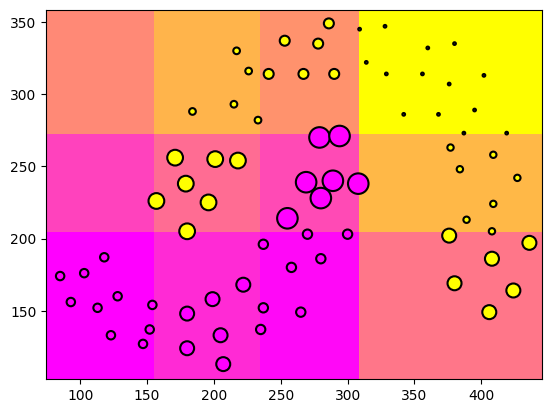

In [5]:
T = 10                   # число алгоритмов в композиции
max_depth = 1           # максимальная глубина решающих деревьев
w = np.ones(XN) / XN    # начальные значения весов для объектов выборки
algs = []               # список из полученных алгоритмов
alfa = []               # список из вычисленных весов для композиции

for n in range(T):
    # создаем и обучаем решающее дерево с весами объектов w
    algs.append(DecisionTreeClassifier(criterion='gini', max_depth=max_depth))
    algs[n].fit(train_data, train_labels, sample_weight=w)

    predicted = algs[n].predict(train_data) # формируем прогнозы дерева по обучающей выборке
    N = np.sum(np.abs(train_labels - predicted) / 2 * w)   # вычисляем weighted error rate
    alfa.append( 0.5 * np.log((1 - N) / N) if N != 0 else np.log((1-1e-8) / 1e-8) ) # вычисляем вес для текущего алгоритма

    # пересчитываем веса объектов выборки
    w = w * np.exp(-1 * alfa[n] * train_labels * predicted)
    w = w / np.sum(w)


# вычисляем число ошибок классификации на основе полученной композиции
predicted = alfa[0] * algs[0].predict(train_data)
for n in range(1, T):
    predicted += alfa[n] * algs[n].predict(train_data)

N = np.sum(np.abs(train_labels - np.sign(predicted)) / 2)
print(f"Число ошибок на обучающей выборке: {N} при композиции {T} решающих деревьев")


# отображаем полученные результаты классификации
xx, yy = get_grid(train_data)
predicted = alfa[0] * algs[0].predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
for n in range(1, T):
    predicted += alfa[n] * algs[n].predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx, yy, predicted, cmap='spring', shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=5000 * w, cmap='spring', edgecolors='black', linewidth=1.5)
plt.show()

As you can see from the code, **predictions on a test sample** can be obtained as follows:  
1. Get predictions of a test sample on each classifier from the set;
2. Weigh predictions using $\alpha_t$;
3. Sum them up;  
4. Take the sign from the result  

This process is very similar to bagging or pasting, except that the predictors have different weights depending on their accuracy on a weighted training sample.

In [6]:
w = np.ones(XN) / XN

In [7]:
w = w * np.exp(-1 * alfa[0] * train_labels * algs[0].predict(train_data))
w

array([0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.02896577,
       0.00597706, 0.00597706, 0.02896577, 0.02896577, 0.00597706,
       0.02896577, 0.02896577, 0.02896577, 0.02896577, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.00597706, 0.00597706, 0.00597706, 0.00597706, 0.00597706,
       0.02896577, 0.02896577, 0.02896577, 0.00597706, 0.02896577,
       0.02896577, 0.02896577, 0.00597706, 0.00597706, 0.00597

In [8]:
w = w / np.sum(w)
w

array([0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.03846154,
       0.00793651, 0.00793651, 0.03846154, 0.03846154, 0.00793651,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.00793651, 0.00793651, 0.00793651, 0.00793651, 0.00793651,
       0.03846154, 0.03846154, 0.03846154, 0.00793651, 0.03846154,
       0.03846154, 0.03846154, 0.00793651, 0.00793651, 0.00793

In [9]:
train_data[0:2]

array([[ 85, 174],
       [ 93, 156]])

In [10]:
train_labels[0:2]

array([-1., -1.])

#### WARNING

There is one big drawback to this kind of sequential learning technique: it **cannot be parallelized**, since each predictor can be trained only after the previous predictor has been trained and evaluated.  

As a result, it cannot be scaled, just like bagging or pasting.

## Adaboost python code (regression)

In [11]:
X, y = make_regression(n_samples=15, n_features=3, random_state=10)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.32, random_state=10)

In [12]:
df = pd.DataFrame(X)
df['y_true'] = y
df['y_shifts'] = y

T = 2                   # число алгоритмов в композиции
max_depth = 1           # максимальная глубина решающих деревьев
algs = []               # список из полученных алгоритмов
for n in range(T):
    algs.append(DecisionTreeRegressor(max_depth=max_depth))
    algs[-1].fit(df[[0, 1, 2]], df['y_shifts'])          # обучаемся предсказывать остатки

    df['y_shifts'] -= algs[-1].predict(df[[0, 1, 2]])    # пересчитываем остатки
    df['y_shifts_' + str(n)] = df['y_shifts'].copy()


# восстанавливаем целевую переменную по набору полученных алгоритмов
yy = algs[0].predict(df[[0, 1, 2]])
for n in range(1, T):
    yy += algs[n].predict(df[[0, 1, 2]])

df['y_predicted'] = yy

df

,0,1,2,y_true,y_shifts,y_shifts_0,y_shifts_1,y_predicted
0,-0.174600,0.433026,1.203037,38.419160,-35.235351,-12.786909,-35.235351,73.654511
1,1.123691,1.672622,0.099149,121.357412,47.702901,70.151342,47.702901,73.654511
2,-0.939433,-0.489337,-0.804591,-115.439344,-18.838621,-52.511283,-18.838621,-96.600723
3,-0.008384,0.621336,-0.720086,-18.956311,-36.489718,-70.162380,-36.489718,17.533407
4,1.331587,0.715279,-1.545400,60.787849,43.254442,9.581780,43.254442,17.533407
5,-0.731970,0.660232,-0.350872,-63.600393,-23.120774,-0.672333,-23.120774,-40.479619
6,-1.743372,0.266070,2.384967,-47.517540,-7.037921,15.410520,-7.037921,-40.479619
7,-0.267317,-0.549309,0.132708,-25.154965,15.324654,37.773096,15.324654,-40.479619
8,1.484537,-1.079805,-1.977728,29.607303,12.073896,-21.598766,12.073896,17.533407
9,0.400210,-0.337632,1.256472,76.021003,2.366492,24.814933,2.366492,73.654511


In [13]:
y_test_pred = algs[0].predict(X_test)
for n in range(1, T):
    y_test_pred += algs[n].predict(X_test)

print('Train error: ', mean_squared_error(df['y_true'], df['y_predicted']))
print('Test error: ', mean_squared_error(y_test, y_test_pred))

Train error:  804.4763430561741
Test error:  1923.084031539592


## Adaboost classifier in sklearn

Scikit-learn uses a multiclass version of AdaBoost called **SAMME** (Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are only two classes in the sample, SAMME is equivalent to the usual AdaBoost.

Moreover, if predictors can estimate the probabilities of classes (i.e., if they have the predict_proba() method implemented), scikit-learn can use a variant of SAMME called **SAMME.R**, which is based on class probabilities rather than predictions (and generally works better).  

Tree of ``max_depth=1`` (**decision stumps**, решающие пни) is commonly used as a base estimator in Adaboost.

It is also said on stackoverflow that the AdaBoostClassifier in sklearn trains each stump not on the entire sample, but on a **bootstraped sample**.

*'Adaboost performs bootstrapping on the dataset, and observations are drawn based on the weights, so observations with larger weights are more likely to appear in the next iteration'*

The following code trains the AdaBoostClassifier based on 200 Decision Stumps using the ``AdaBoostClassifier`` class:

In [20]:
Xm, ym = make_moons(n_samples=500, noise=0.30, random_state=42)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, random_state=42)

In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
    algorithm="SAMME", learning_rate=0.1)
ada_clf.fit(Xm_train, ym_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=500)

All three key parameters of AdaBoost are listed here:  
1) maximum depth of the decision tree;  
2) number of algorithms in the ensemble;  
3) learning rate.



The last two should be selected on cross-validation to find a balance between **over-fitting** and **under-fitting**.  

Look at the AdaBoost decision boundary:

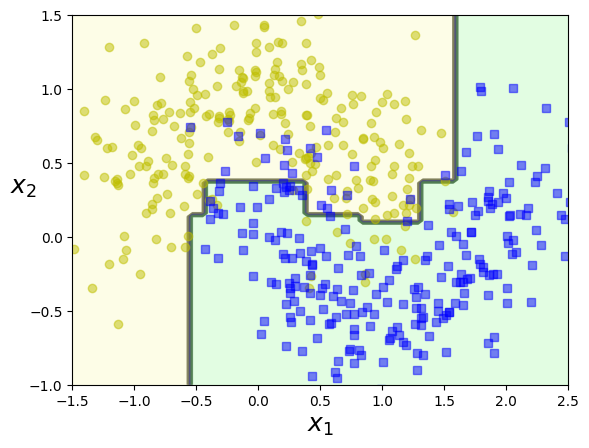

In [26]:
plot_decision_boundary(ada_clf, Xm, ym) # learning rate 0.1

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(ada_clf.predict(Xm_test), ym_test)



0.912

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


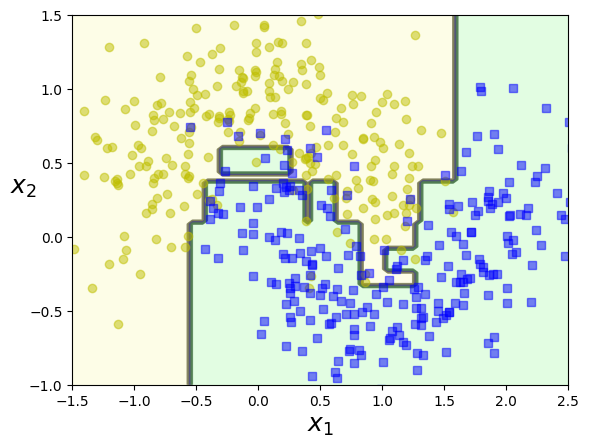

In [31]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=1)
ada_clf.fit(Xm_train, ym_train)

plot_decision_boundary(ada_clf, Xm, ym)  # learning rate 1

We typically use a validation sample to track overfitting, since on real data, we don't have a chance to visualize this boundary.  

**If the AdaBoost ensemble has overfit**, you can:  
- Reduce the number of base estimators;  
- Reduce the learning rate;  
- Set a more stringent regularization for base estimators (e.g., train each stump using random n attributes from X)  

**The disadvantages of AdaBoost algorithm**:  

- Excessive **sensitivity to outliers** - the goal of the algorithm is to achieve maximum accuracy on all data, so it adjusts to outliers. However, this can be dealt with if we filter out objects with large weights (the weight of an object gradually increases if it is poorly handled by the composition).    
  
- AdaBoost builds "black boxes" - algorithms that are difficult to interpret (it becomes very difficult to understand why we got some value as an output from a composition of trees);  
  
- It is not possible to build short compositions (for small $T$) from "strong" algorithms (for example, SVM and neural networks).  
  
- A **large training sample** is needed (bagging can be done with shorter ones).

# 2. **Gradient Boosting**

Another popular boosting algorithm is gradient boosting. Gradient boosting is one of the variants of ensemble methods where you create multiple weak models and combine them to get better performance as a whole.

Gradient boosting is a universal boosting algorithm that works with an **arbitrary smooth and differentiable loss function**.  

The same **greedy** approach: 1) fix previously found algorithms; 2) look for the best algorithm according to the quality criterion.  

At first, we need to select:  
1. Loss function (squared error, log loss, exponential loss)  
2. Algorithm to build a composition on (typically decision tree)   

#### NOTE

Unlike AdaBoost, stumps are rarely used in gradient boosting.  
Usually, the number of terminal nodes (leaves) is selected in the range from **8 to 32**.  
However, further we will use stumps for demonstration purposes.

#### References

- **StatQuest, Gradient Boost [Part1](https://www.youtube.com/watch?v=3CC4N4z3GJc&t=1s) and [Part 2](https://www.youtube.com/watch?v=2xudPOBz-vs)**

This is a YouTube video explaining GB regression algorithm with great visuals in a beginner-friendly way.

- **Terence Parr and Jeremy Howard, [How to explain gradient boosting](https://explained.ai/gradient-boosting/index.html)**

This article also focuses on GB regression. It explains how the algorithms differ between squared loss and absolute loss.

- **Jerome Friedman, [Greedy Function Approximation: A Gradient Boosting Machine](https://jerryfriedman.su.domains/ftp/trebst.pdf)**

This is the original paper from Friedman. While it is little hard to understand it, it surely shows the beauty of the algorithm where he shows a generalized algorithm that can deal with any problem having a differentiable loss function.

- Matt Bowers, [How to Build a Gradient Boosting Machine from Scratch](https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch)
- Wikipedia, [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)

## Regression case (example)



**CREDITS**: explanation and notebook by [StatQuest](https://towardsdatascience.com%2Fall-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502&cc_key=) (access only via VPN)

[Youtube video](https://www.youtube.com/watch?v=3CC4N4z3GJc)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

sns.set()

Imagine we have the following data. Our goal is to predict $y$ by $x$.

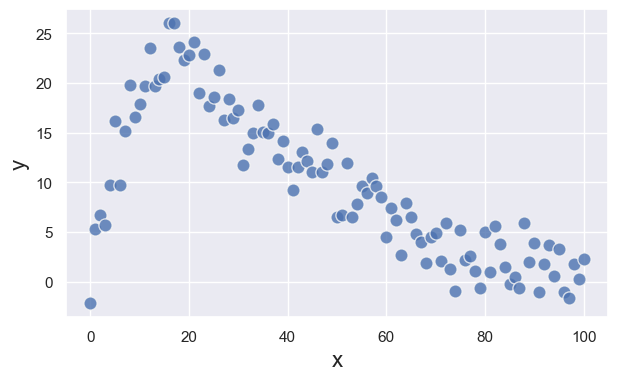

In [33]:
np.random.seed(123)
x = np.linspace(0, 100, 101)
# generating y using gamma distribution
y = (stats.gamma.pdf(x, a=2, loc=0, scale=17) + np.random.normal(0,0.002,101)) * 1000
x = x.reshape(-1,1)

plt.rcParams["figure.figsize"] = (7, 4)
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

The first step is making a very **naive prediction** on the target y. We make the initial prediction F₀ as an overall **average** of y:

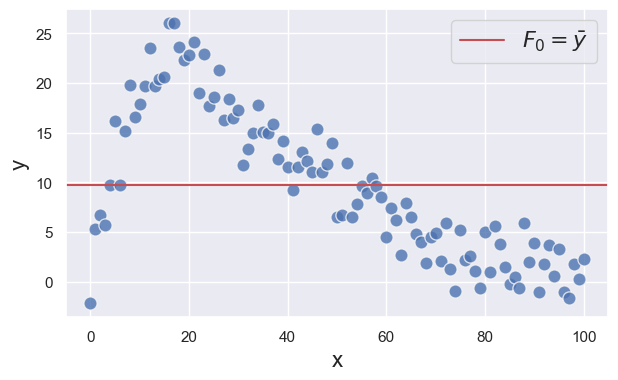

In [34]:
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.axhline(y=y.mean(), color='r', linestyle='-', label=r'$F_{0} = \bar{y}$')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=16)
plt.show()

Now, for each instance, let's calculate how wrong our prediction was. In other words, we'll calculate **residuals** (остатки).

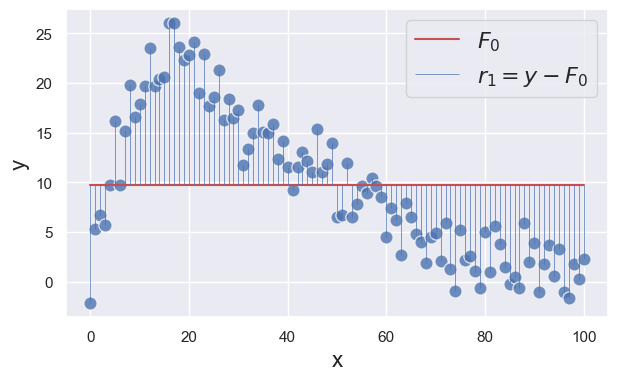

In [35]:
def plot_residuals(x, y, Fm, i, ax, title = ""):

    fltr_smaller = y < Fm
    fltr_bigger = y >= Fm

    ax.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    ax.plot(x, Fm, c='r', label=f'$F_{i}$')
    ax.vlines(x[fltr_smaller], y[fltr_smaller], Fm[fltr_smaller], linewidth=0.5, color='b', label=f'$r_{i+1} = y - F_{i}$')
    ax.vlines(x[fltr_bigger], Fm[fltr_bigger], y[fltr_bigger], linewidth=0.5, color='b')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.legend(fontsize=16)

fig, ax = plt.subplots(1, 1)
F0 = np.full(len(y), y.mean())
plot_residuals(x, y, F0, 0, ax)
plt.show()

We would like to **minimize** these residuals to make our predictions close to $y$.

To do this, we can **train** another weak learner **to predict these residuals**: if we can find some patterns between x and r by building the additional weak model, we can reduce the residuals by utilizing it.

So, we are building a regression tree model with $x$ as its feature and the residuals $r = y − mean(y)$ as its target

In [36]:
# this function print out tree structures. adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def print_tree(clf):

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print('-'*80)
    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node.".format(
                    space=node_depth[i] * "\t", node=i
                )
            )
            print(node_depth[i] * '\t', f"prediction: {clf.tree_.value[i, 0, 0]:.1f}")
        else:
            print(
                "{space}node={node} is a split node: "
                "go to node {left} if X[:, {feature}] <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature[i],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )
    print('-'*80)

def train_and_update(x, y, Fm, learing_rate=0.1):

    r = y - Fm
    tree = DecisionTreeRegressor(max_depth=1, random_state=0)
    tree.fit(x, r)
    gamma = tree.predict(x)
    Fm = Fm + learing_rate * gamma

    return tree, Fm, gamma, r


def plot_gamma(x, residuals, gamma, i, ax, title = ""):

    ax.scatter(x, residuals, edgecolors='whitesmoke', color = 'g', s=90, alpha=0.8, label=f'$r_{i} = y – F_{i-1}$')
    ax.plot(x, gamma, c='b', label=f'$γ_{i}$')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("x", fontsize=16)
    ax.set_ylabel("r", fontsize=16)
    ax.legend(fontsize=16)

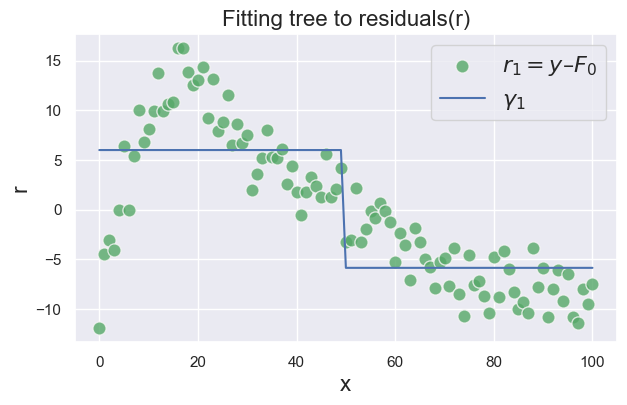

--------------------------------------------------------------------------------
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 49.5 else to node 2.
	node=1 is a leaf node.
	 prediction: 6.0
	node=2 is a leaf node.
	 prediction: -5.9
--------------------------------------------------------------------------------


In [37]:
tree, Fm, gamma, r = train_and_update(x, y, F0, learing_rate=0.9)

fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 1, ax, "Fitting tree to residuals(r)")
plt.show()
print_tree(tree)

The result of predicting the residuals is denoted by γ (gamma).  


To simplify the demonstration, we are building very simple trees each of that only has one split and two terminal nodes which is called "**stump**".  
Please note that gradient boosting trees usually have a little deeper trees such as ones with 8 to 32 terminal nodes.   
Here we are creating the first tree predicting the residuals with two different values γ₁ = {6.0, −5.9}.

This prediction γ₁ is added to our initial prediction F₀ to reduce the residuals. In fact, gradient boosting algorithm does not simply add γ to F as it makes the model overfit to the training data. Instead, γ is scaled down by **learning rate** ν which ranges between 0 and 1, and then added to F.

$$F₁ = F₀ + ν∙γ₁$$

In this example, we use a relatively big learning rate ν = 0.9 to make the optimization process easier to understand, but it is usually supposed to be a much smaller value such as 0.1.
After the update, our combined prediction F₁ becomes:

$$
F₁ = \begin{cases}
    F₀+ν∙6.0 & \text{if } x≤49.5 \\
    F₀-ν∙5.9 & \text{otherwise}
\end{cases}
$$

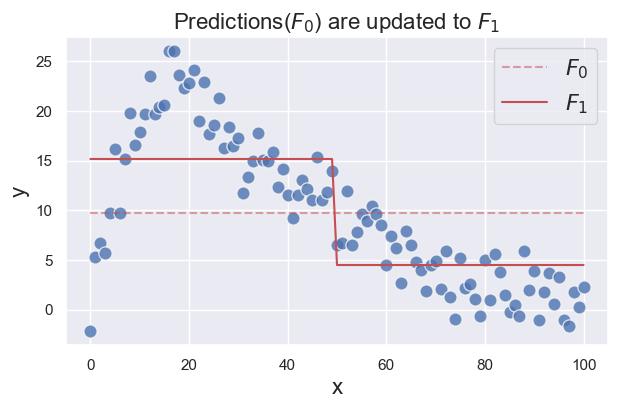

In [38]:
def plot_update(x, y, Fm, Fm_pre, i):

    plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    plt.plot(x, Fm_pre, c='r', linestyle='--', label=f'$F_{i-1}$', alpha=0.5)
    plt.plot(x, Fm, c='r', label=f'$F_{i}$')
    plt.title(f"Predictions($F_{i-1}$) are updated to $F_{i}$", fontsize=16)
    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

plot_update(x, y, Fm, F0, 1)

Updated residuals:  

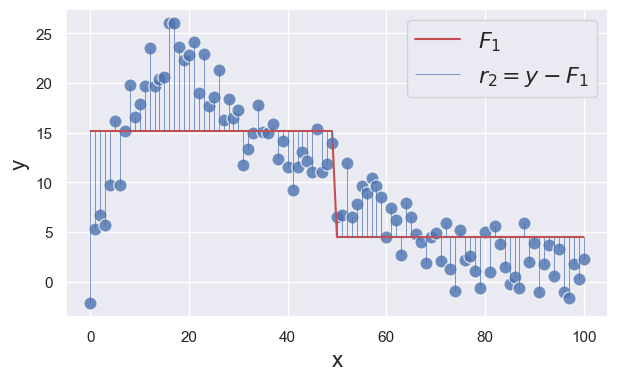

In [39]:
fig, ax = plt.subplots(1, 1)
plot_residuals(x, y, Fm, 1, ax)
plt.show()

In the next step, we are creating a regression tree again using the same x as the feature and the updated residuals r₂ as its target. Here is the created tree:

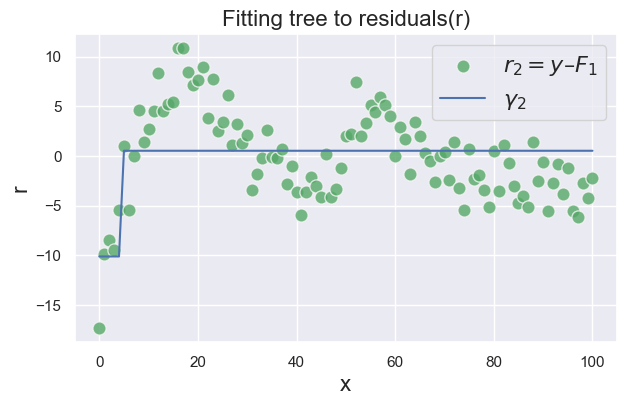

--------------------------------------------------------------------------------
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 4.5 else to node 2.
	node=1 is a leaf node.
	 prediction: -10.1
	node=2 is a leaf node.
	 prediction: 0.5
--------------------------------------------------------------------------------


In [40]:
Fm_pre = Fm.copy()
tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)

fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 2, ax, "Fitting tree to residuals(r)")
plt.show()
print_tree(tree)

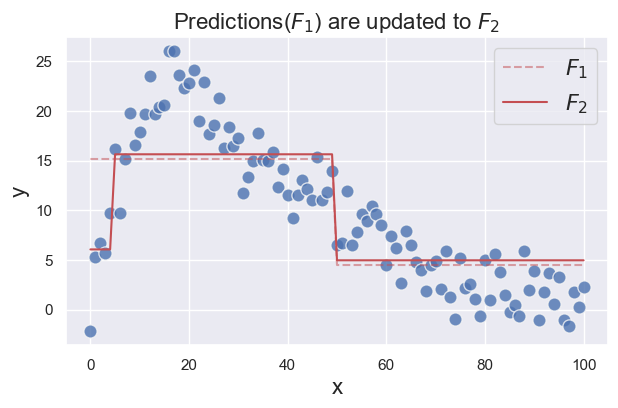

In [41]:
plot_update(x, y, Fm, Fm_pre, 2)

We iterate these steps until the model prediction stops improving. The figures below show the optimization process from 0 to 6 interactions.

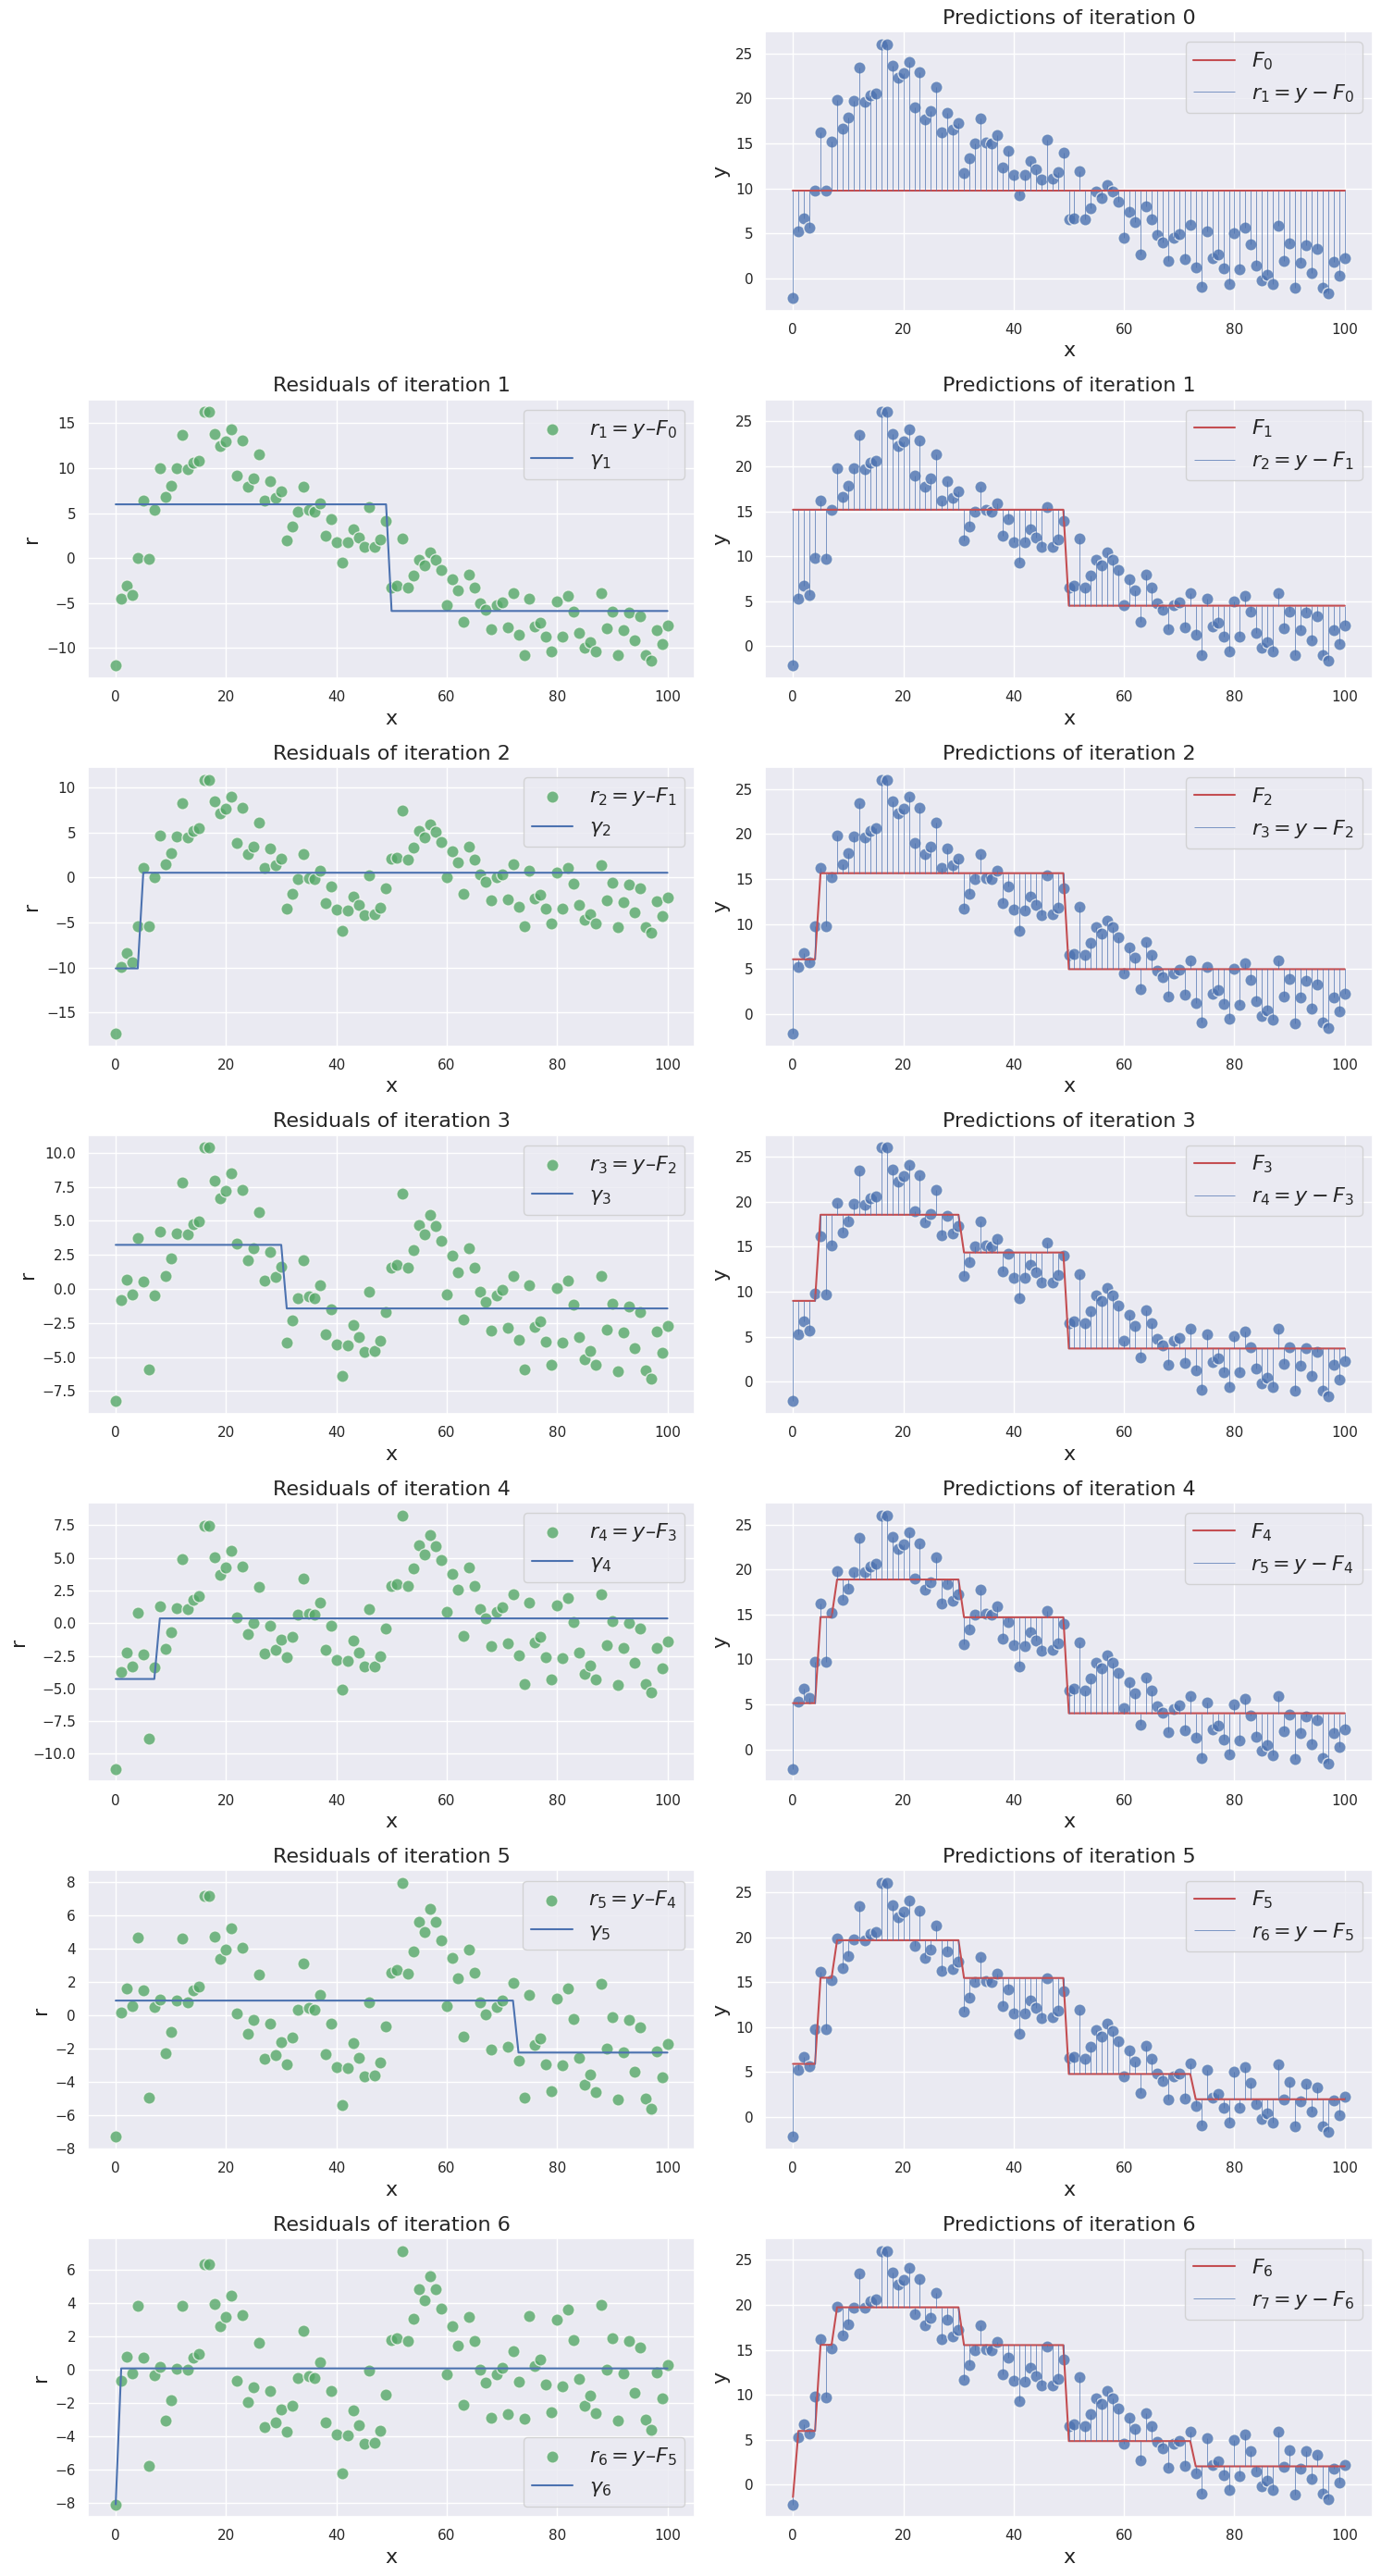

In [ ]:
Fm = F0 = np.full(len(y), y.mean())
n_estimators = 6

fig, axs = plt.subplots(n_estimators+1, 2, figsize=(15, 4*(n_estimators+1)))
axs = axs.flatten()
axs[0].axis('off')

plot_residuals(x, y, F0, 0, axs[1], title="Predictions of iteration 0")

for i in range(n_estimators):
    tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)

    j = 2 + i*2
    plot_gamma(x, r, gamma, i+1, axs[j], f"Residuals of iteration {i+1}")
    plot_residuals(x, y, Fm, i+1, axs[j+1], title=f"Predictions of iteration {i+1}")

plt.tight_layout()
plt.show()

## Regression case (math)

The algorithm is as follows:  

1. Initialization of the constant predictions: $ argmin \sum_{i=1}^{l}L(y_i, F_0)$ (find the value $F_0$ that minimizes the Loss);
  
2. For each algorithm from $b_1$ to $b_T$:  
  
3. Compute the residuals: $- grad(L)$ with respect to $F_{t-1}$ (find the value $r_{i, t}$ that shows us the direction and magnitude in which the loss can be minimized);
  
4. Train a regression tree $b_t$ with features $X$ to predict the computed residuals, get $J$ leaves (terminal nodes).  
  
5. Get the predictions of the residuals: $γ_{j, t} = argmin_γ \sum_{x_i∈R_{j, m}}L(y_i, F_{t-1} + γ)$, for each DT leave $j=1, ..., J$  
  
6. Update the predictions of the ensemble model: $F_t(X) = F_{t-1}(X) + \eta \sum_{j=1}^{J, t}γ_{j, m}$, $X∈R_{j, m}$  
  
Finish: Return $F_T$

By $F_t$, we denote the prediction of the whole composition on a step $t$  
By $γ_{j, t}$, we denote the result of a prediction of the residuals in a leaf $j$ of a decision tree $t$  
$\eta$ is a learning rate  
$l$ is the number of objects in the training sample

**Step 1**



> Initialization of the constant predictions: $ argmin \sum_{i=1}^{l}L(y_i, F_0)$ - find the value $F_0$ that minimizes the Loss



For the regression case, our loss function is typically **squared error loss**

$$ Q_T = \sum_{i=1}^{l} (y_i - F_0)^2 --> min $$

To find the minimum of the function at the $F_0$ point, we can use the **least squares method**, i.e.:
- calculate the derivative with respect to the $F_0$ parameter: $\frac{\partial}{\partial_γ}\sum_{i=1}^{l}(y_i - F_0)^2 = ... = -2\sum_{i=1}^{l}(y_i + 2lF_0)^2$
- equate it to zero: $-2\sum_{i=1}^{l}(y_i + 2lF_0)^2 = 0$
- express $F_0$: $F_0 = \frac{1}{n}\sum_{i=1}^{l}y_i$

It turns out that the $F_0$ that minimizes the squared error function the most is the **mean value of $y$**. That's why we predicted it first.

$F_0 = mean(y)$  
(only for squared loss!)

**Step 2**



> For each algorithm from $b_1$ to $b_T$:



We iterate over the algorigms and repeat steps from 3 to 6 $T$ times, i.e. as many times as we have trees in our composition.  

**Step 3**



> Compute the residuals: $- grad(L)$ with respect to $F_{t-1}$ (find the value $r_{i, t}$ that shows us the direction and magnitude in which the loss can be minimized);



To calculate the residual for the object $x_i$, we calculate the partial derivative of the loss function at the point $F_{t-1}(x_i)$ and multiply it by -1.  
  
$$r_{i, t} = - [\frac{\partial L(y_i, F_{t-1}(x_i))}{\partial F_{t-1}(x_i)}]$$
  
What we get is a **negative gradient**.   

By calculating the residuals for all objects (from $1$ to $l$), we will get a vector of anti-gradients, which will indicate to us the direction of the fastest decrease in the function.

Let's calculate the negative gradient (residual) for the squared error loss function:  

$$r_{i, t} = - \frac{\partial (y_i - F_{t-1}(x_i))^2}{\partial F_{t-1}(x_i)}$$  
$$r_{i, t} = 2(y_i - F_{t-1}(x_i))$$


'2' can be cancelled if we take squared error with $\frac{1}{2}$.  
  
$$r_{i, t} = y_i - F_{t-1}(x_i)$$  
  
We get that the negative gradient in the case of a **squared error loss function** really **corresponds to the residuals**.

**Step 4**

> Train a regression tree $b_t$ with features $X$ to predict the computed residuals, get $J$ leaves (terminal nodes).



We will denote any leaf as $R$.   
$R_{j, t}$ - the leaf $j$ of the decision tree $b_t$

**Step 5**



> Get the predictions of the residuals: $γ_{j, t} = argmin_γ \sum_{x_i∈R_{j, m}}L(y_i, F_{t-1} + γ)$, for each DT leave $j=1, ..., J$



We need to predict values in such a way that **the squared error is minimal** at each node of the tree.

Let's put the squared error loss function in the equation:

$$γ_{j, t} = argmin_γ \sum_{x_i∈R_{j, m}}(y_i - F_{t-1} - γ)^2$$

$y_i - F_{t-1}$ is nothing but a residual on an object $x_i$ on a step $t$:

$$γ_{j, t} = argmin_γ \sum_{x_i∈R_{j, m}}(r_{i, t} - γ)^2$$

Using the minimum squares method, we get that the optimal value of $γ_{j, t}$ is **the mean value** among all objects $n$ that fall into the terminal node (leaf):  


$$γ_{j, t} = \frac{1}{n}\sum_{x_i∈R_{j, m}}r_{i, t}$$

Simply put, in order to get closer to the target variable through the residuals, it is necessary to predict the average of the residuals in the leaves.

**Step 6**



> Update the predictions of the ensemble model: $F_t(X) = F_{t-1}(X) + \eta \sum_{j=1}^{J, t}γ_{j, m}$, $X∈R_{j, m}$



To the previous predictions of the ensemble, we add our predictions of the residuals.  
$X∈R_{j, m}$ shows, that we select the $γ_{j, m}$ value if the specified group of objects $X$ falls into a leaf $R_{j, m}$

If we have a tree of depth 1, then there will be two groups in total, and we will add only two groups of values.  

$\eta$ is a learning rate, ranging between 0 and 1.  
It controls the degree of contribution of the tree predictions to the combined prediction.  
If you set it very low (for example 0.1), then you will need more trees in the ensemble to learn, but forecasts will usually generalize better.  
Still, you have to be careful with the number of trees.



## Why we need all this math?

Some of you might feel that all those maths are unnecessarily complex as the previous section showed the basic idea in much simpler way without all those complications.  
  
The reason behind it is that gradient boosting is designed to be able to deal with **any loss functions** as long as they are differentiable. In this sense, GB is very flexible and convenient to work with.  
  
Just select the loss function and the algorithm is ready to solve the problem.

## Code (finally)

The code is mostly derived from [Matt Bowers' implementation](https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch#Implementation), so all credit goes to his work. We are using DecisionTreeRegressor from scikit-learn to build trees which helps us just focus on the gradient boosting algorithm itself instead of the tree algorithm. We are imitating scikit-learn style implementation where you train the model with fit method and make predictions with predict method.  

In [43]:
class CustomGradientBoostingRegressor:

    def __init__(self, learning_rate, n_estimators, max_depth=1):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):

        self.F0 = y.mean()
        Fm = self.F0  # naive prediction

        for _ in range(self.n_estimators):
            r = y - Fm                                                                # calculate residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=0)    # create tree
            tree.fit(X, r)                                                            # fit it with X and residuals
            gamma = tree.predict(X)                                                   # predict residuals (averages from leaves)
            Fm += self.learning_rate * gamma                                          # contribute to the composition prediction
            self.trees.append(tree)                                                   # save the current predictor

    def predict(self, X):

        Fm = self.F0

        for i in range(self.n_estimators):
            Fm += self.learning_rate * self.trees[i].predict(X)           # final prediction
                                                                          # target mean + sum of the predicted residuals mult. by lr
        return Fm

Please note that all the trained trees are stored in self.trees list object and it is retrieved when we make predictions with predict method.

Next, we are checking if our CustomGradientBoostingRegressor performs as the same as GradientBoostingRegressor from scikit-learn.

In [44]:
print(x[0:4])
print(y[0:4])

[[0.]
 [1.]
 [2.]
 [3.]]
[-2.17126121  5.25722772  6.71827371  5.68869188]


In [46]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

custom_gbm = CustomGradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=1
)
custom_gbm.fit(x, y)
custom_gbm_rmse = mean_squared_error(y, custom_gbm.predict(x))
print(f"Custom GBM RMSE:{custom_gbm_rmse:.15f}")

sklearn_gbm = GradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=1
)
sklearn_gbm.fit(x, y)
sklearn_gbm_rmse = mean_squared_error(y, sklearn_gbm.predict(x))
print(f"Scikit-learn GBM RMSE:{sklearn_gbm_rmse:.15f}")

Custom GBM RMSE:15.695124439800960
Scikit-learn GBM RMSE:15.695124439800960


## Gradient Tree Boosting in sklearn

The simplest way to train GBRT ensembles is to use the ``GradientBoostingRegressor`` class in Scikit-learn.
Like the ``RandomForestRegressor`` class, it has hyperparameters that control the growth of decision trees (for example, ``max_depth``, ``min_samples_leaf``, etc.), as well as hyperparameters that control ensemble learning, for example, the number of trees (``n_estimators``).  



In [49]:
np.random.seed(42)
X_r = np.random.rand(100, 1) - 0.5
y_r = 3*X_r[:, 0]**2 + 0.05 * np.random.randn(100)

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

def create_fit_gbrt(n_estimators, learning_rate):
  gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=n_estimators, learning_rate=learning_rate)
  gbrt.fit(X_r, y_r)
  return gbrt

In [51]:
gbrt_big_fast = create_fit_gbrt(200, 1)
gbrt_big_slow =  create_fit_gbrt(200, 0.1)
gbrt_small_fast =  create_fit_gbrt(3, 1)
gbrt_small_slow = create_fit_gbrt(3, 0.1)
gbrt_optimal = create_fit_gbrt(50, 0.1)

The ``learning_rate`` hyperparameter sets the degree of contribution of each tree.  
As already mentioned, reducing this parameter is one of the regularization techniques called *shrinkage* (сжатие).  

Small ``learning_rate`` will require more trees in an ensemble to reduce the bias, but will eventually lead to better generalization.  

The plots below demonstrate that choosing between appropriate values of ``n_estimators`` and ``learning_rate`` is the trade-off between bias and variance.  

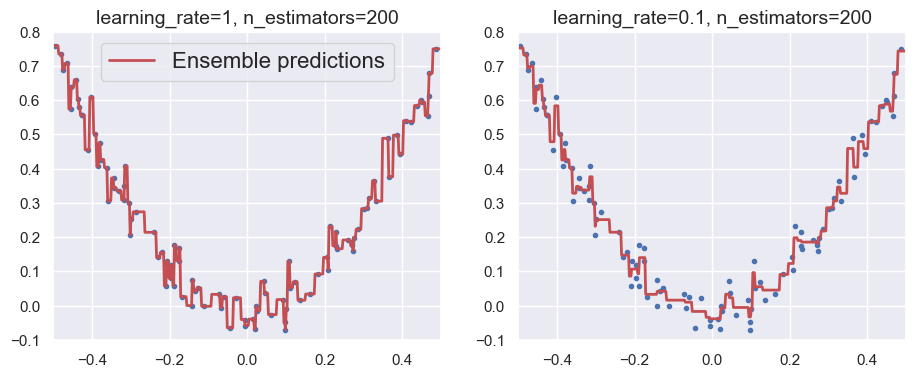

In [52]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt_big_fast], X_r, y_r, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_big_fast.learning_rate, gbrt_big_fast.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_big_slow], X_r, y_r, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_big_slow.learning_rate, gbrt_big_slow.n_estimators), fontsize=14)

plt.show()

Text(0.5, 1.0, 'learning_rate=0.1, n_estimators=3')

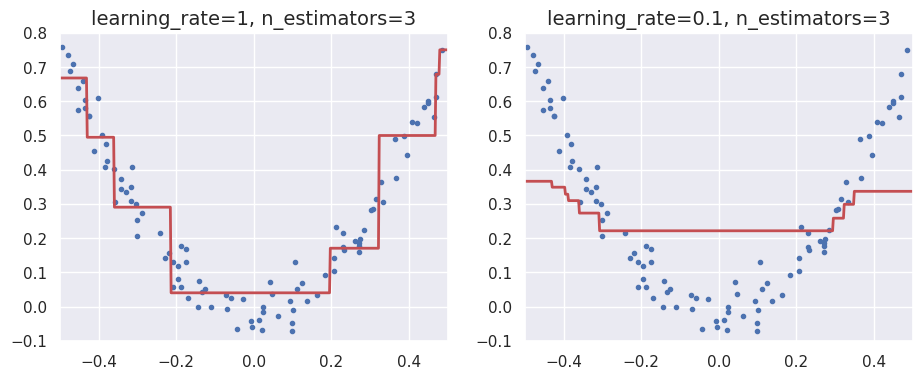

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt_small_fast], X_r, y_r, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_small_fast.learning_rate, gbrt_small_fast.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_small_slow], X_r, y_r, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_small_slow.learning_rate, gbrt_small_slow.n_estimators), fontsize=14)

Text(0.5, 1.0, 'learning_rate=0.1, n_estimators=50')

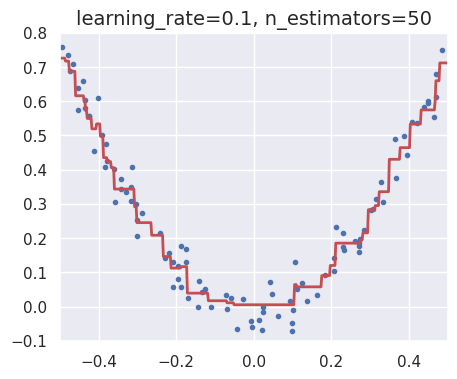

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt_optimal], X_r, y_r, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_optimal.learning_rate, gbrt_optimal.n_estimators), fontsize=14)

To find the optimal number of trees in the GB ensemble, you can use **early stopping**.  
It is easy to implement using the ``staged_predict()`` method: it returns an iterator based on the predictions developed by the ensemble at each stage of training (with one tree, two trees, etc.).

In [ ]:
Xr_train, Xr_val, yr_train, yr_val = train_test_split(X_r, y_r)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, learning_rate=0.1, random_state=10)
gbrt.fit(Xr_train, yr_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=10)

In [ ]:
gbrt.staged_predict(Xr_val)

<generator object GradientBoostingRegressor.staged_predict at 0x792f8d808d60>

In [ ]:
errors = [mean_squared_error(yr_val, y_pred)
          for y_pred in gbrt.staged_predict(Xr_val)] # iterating over validation errors

In [ ]:
bst_n_estimators = np.argmin(errors)
bst_n_estimators                      # the best number of estimators

66

In [ ]:
min_error = np.min(errors)
min_error                             # the smallest error

0.003021772761385236

In [ ]:
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, learning_rate=0.1)
gbrt_best.fit(Xr_train, yr_train)

GradientBoostingRegressor(max_depth=2, n_estimators=66)

Validation errors are shown on the left, and predictions of the best model are shown on the right.  

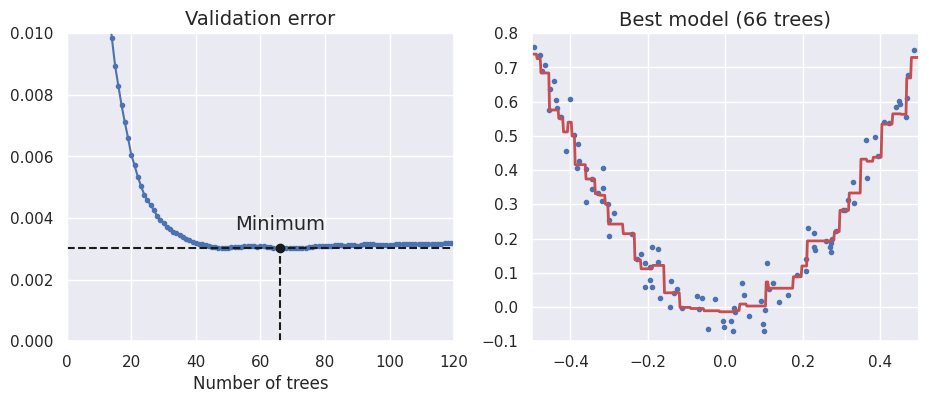

In [ ]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X_r, y_r, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

In addition, in order to increase the generalizing ability of the ensemble, an approach called **stochastic gradient boosting** can be used.

The `GradientBoostingRegressor` class supports the `subsample` parameter, which specifies the proportion of training objects to be used for training each tree. For example, if ``subsample=0.25``, then each tree is trained on 25% of the training samples randomly selected.  

Thus, if we train each tree from step $t$ on a random subsample, it will lead to:  

- the better quality of the entire composition;
- an increase in the rate of convergence (the minimum of the loss is searched faster; in the case of regression decision trees, the average values in nodes are calculated faster, residuals are calculated faster, etc.);
- a decrease in learning time.  

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=70, learning_rate=0.1, subsample=0.25)
gbrt.fit(Xr_train, yr_train)

GradientBoostingRegressor(max_depth=2, n_estimators=70, subsample=0.25)

Text(0.5, 1.0, 'learning_rate=0.1, n_estimators=70')

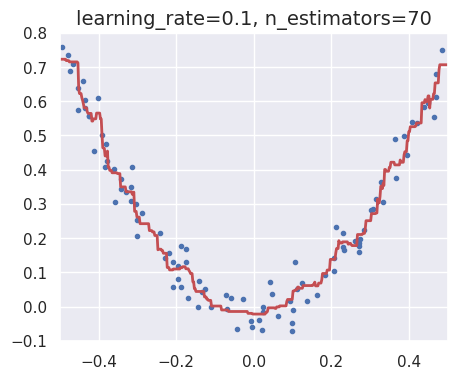

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X_r, y_r, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

# Article about [modern boosting algorithms](https://habr.com/ru/companies/otus/articles/778714/)

# Task

Load the MNIST data, and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier and Logistic Regression. Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

